In [2]:
#importing modules
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization,Dropout
import numpy as np
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#loading dataset 
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    image_size=(256,256),
    batch_size=32
)

Found 2702 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['Negative', 'Positive']

In [5]:
#finding how many total batches of images are there
len(dataset)

85

2026-02-09 13:32:55.952487: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


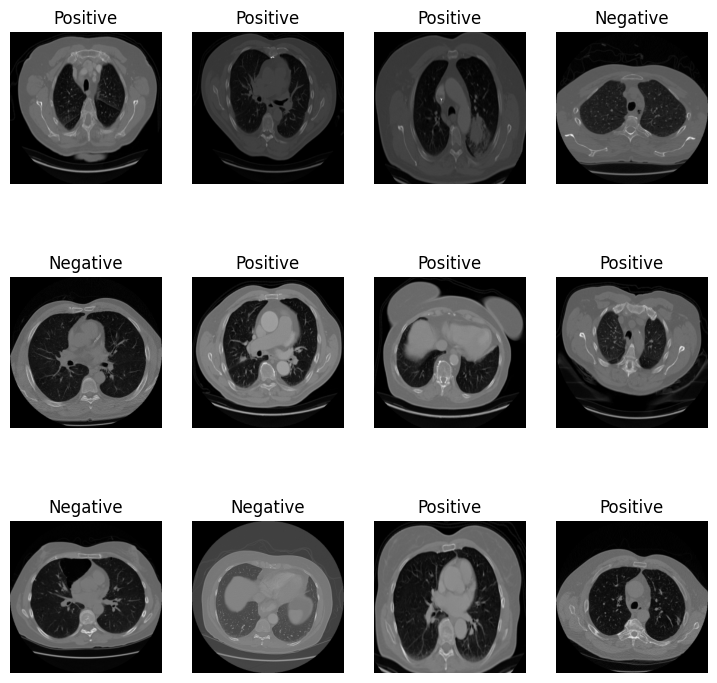

In [6]:
#Vizualizing the dataset 
plt.figure(figsize=(9,9))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
      ax=plt.subplot(3,4,i+1)  
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])  
      plt.axis("off")  

In [7]:
#A function to split the dataset into training,validation and testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
#Splitting the dataset into training, validation and testing
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds),len(val_ds),len(test_ds)

(68, 8, 9)

In [10]:
#Shuffling and PreFetching the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
#Resizing and Rescaling the Images
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255),
])

In [12]:
#Performing Data Augumentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.5),
])

In [33]:
from keras import backend as K
K.clear_session()

In [34]:
input_shape = (256, 256, 3)

model = tf.keras.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax"),
])


In [16]:
dummy = tf.zeros((1, 256, 256, 3))
_ = model(dummy)


In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (1, 256, 256, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (1, 254, 254, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 254, 254, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (1, 127, 127, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 125, 125, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 125, 125, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (1, 62, 62, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 60, 60, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 60, 60, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (1, 30, 30, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 28, 28, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (1, 28, 28, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (1, 14, 14, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (1, 12, 12, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (1, 12, 12, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (1, 6, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (1, 4, 4, 64)          │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (1, 4, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (1, 2, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 64)                │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 2)                 │           13

 Total params: 185,090 (723.01 KB)

 Trainable params: 184,386 (720.26 KB)

 Non-trainable params: 704 (2.75 KB)

In [36]:
#Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
#Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[early_stopping]
    
)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 57s 828ms/step - accuracy: 0.8251 - loss: 0.4667 - val_accuracy: 0.5039 - val_loss: 0.6913
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 63s 920ms/step - accuracy: 0.9128 - loss: 0.2188 - val_accuracy: 0.5508 - val_loss: 0.7034
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 66s 975ms/step - accuracy: 0.9149 - loss: 0.2131 - val_accuracy: 0.5898 - val_loss: 0.6523
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 68s 995ms/step - accuracy: 0.9268 - loss: 0.1736 - val_accuracy: 0.6602 - val_loss: 0.5571
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 67s 987ms/step - accuracy: 0.9350 - loss: 0.1423 - val_accuracy: 0.6016 - val_loss: 0.8153
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 67s 983ms/step - accuracy: 0.9597 - loss: 0.0945 - val_accuracy: 0.6641 - val_loss: 0.8399
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 67s 988ms/step - accuracy: 0.9604 - loss: 0.0976 - val_accuracy: 0.8281 - val_loss: 0.3760
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 68s 996ms/step - accuracy: 0.9677 - loss: 0.0878 - 

In [38]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9700 - loss: 0.0908


[0.09148501604795456, 0.9652777910232544]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

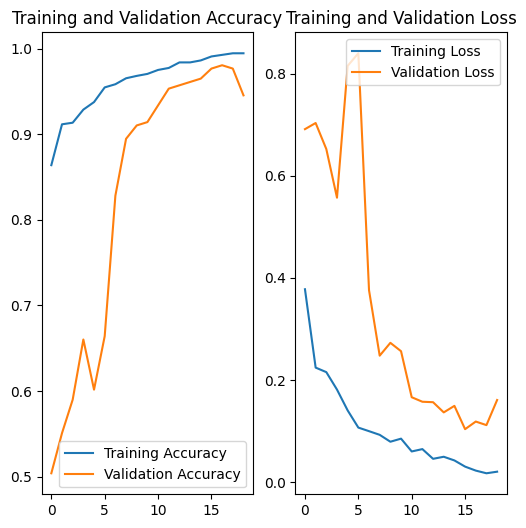

In [41]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(19), acc, label='Training Accuracy')
plt.plot(range(19), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(19), loss, label='Training Loss')
plt.plot(range(19), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2026-02-09 14:11:42.892777: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


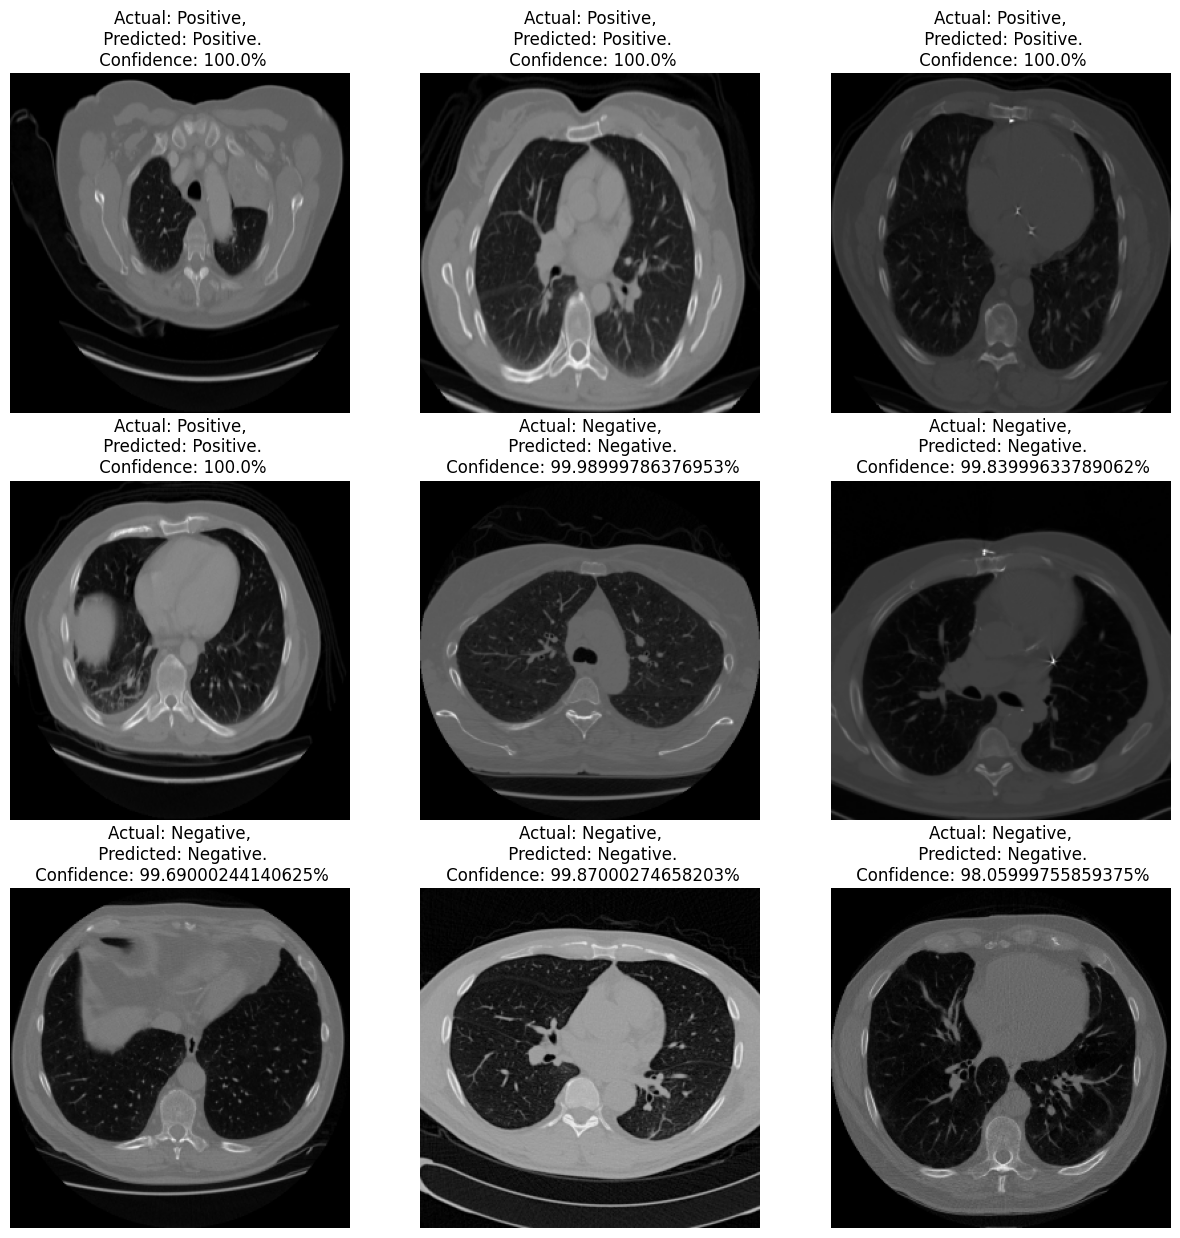

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

X_test shape: (288, 256, 256, 3)
y_true shape: (288,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


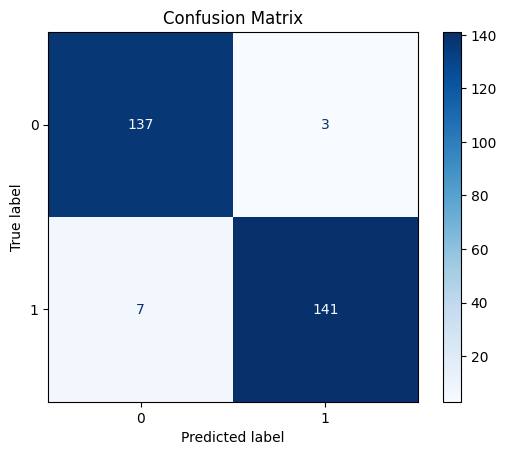


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       140
           1       0.98      0.95      0.97       148

    accuracy                           0.97       288
   macro avg       0.97      0.97      0.97       288
weighted avg       0.97      0.97      0.97       288



In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


#Convert test_ds → NumPy arrays

X_test = []
y_true = []

for images, labels in test_ds:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

print("X_test shape:", X_test.shape)
print("y_true shape:", y_true.shape)


# Predict using your trained model

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Confusion Matrix

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


#Classification Report

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

In [45]:
model.save("saved_models/model1.h5")

In [60]:
#creating seperate folder
import os

base_dir = "Failure_Analysis"
img_dir = os.path.join(base_dir, "failure_images")

os.makedirs(img_dir, exist_ok=True)

## failure analysis


In [61]:
import pandas as pd
import cv2

BASE_DIR = "failure_dataset"
IMG_DIR = os.path.join(BASE_DIR, "images")
os.makedirs(IMG_DIR, exist_ok=True)

# Step 1: Helper proxy functions


def estimate_image_quality(img):
    img_uint8 = img.astype(np.uint8)
    variance = cv2.Laplacian(img_uint8, cv2.CV_64F).var()
    if variance < 50:
        return "Low"
    elif variance < 150:
        return "Medium"
    else:
        return "High"

def estimate_mri_contrast(img):
    contrast = img.max() - img.min()
    if contrast < 40:
        return "Low"
    elif contrast < 120:
        return "Medium"
    else:
        return "High"


# Step 2: Initialize variables

records = []
case_counter = 1


# Step 3: Loop through test dataset

for images, labels in test_ds:

    preds = model.predict(images, verbose=0)

    for i in range(images.shape[0]):
        img = images[i].numpy()
        label_val = labels[i].numpy()

        # ----- True label -----
        if label_val.ndim > 0:
            y_true = int(np.argmax(label_val))
        else:
            y_true = int(label_val)

        # ----- Prediction handling -----
        if preds.shape[1] == 1:  # sigmoid
            prob = float(preds[i][0])
            y_pred = int(prob >= 0.5)
        else:  # softmax
            prob = float(np.max(preds[i]))
            y_pred = int(np.argmax(preds[i]))

        # ----- Only failure cases -----
        if y_true != y_pred:
            failure_type = "FN" if y_true == 1 else "FP"

            # ----- Normalize image -----
            if img.max() <= 1.0:
                img_to_save = (img * 255).clip(0, 255).astype(np.uint8)
            else:
                img_to_save = img.astype(np.uint8)

            # ----- Handle grayscale / RGB -----
            if img_to_save.ndim == 2:
                save_img = img_to_save
            elif img_to_save.shape[-1] == 1:
                save_img = img_to_save[:, :, 0]
            else:
                save_img = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)

            # ----- Save image -----
            case_id = f"{case_counter:03d}"
            image_name = f"{case_id}.png"
            image_path = os.path.join(IMG_DIR, image_name)
            cv2.imwrite(image_path, save_img)

            # ----- Proxy metrics -----
            image_quality = estimate_image_quality(save_img)
            mri_contrast = estimate_mri_contrast(save_img)

            # ----- Record entry -----
            records.append({
                "case_id": case_id,
                "failure_type": failure_type,   # FP or FN
                "true_label": y_true,           # 0 = non-cancer, 1 = cancer
                "predicted_label": y_pred,
                "prediction_probability": round(prob, 4),
                "image_quality": image_quality,
                "mri_contrast": mri_contrast,
                "image_path": image_path
            })

            case_counter += 1


# Step 4: Save Excel file

failure_df = pd.DataFrame(records)
failure_df.to_excel(os.path.join(BASE_DIR, "failure_cases.xlsx"), index=False)

failure_df


,case_id,failure_type,true_label,predicted_label,prediction_probability,image_quality,mri_contrast,image_path
0,001,FP,0,1,0.7346,High,High,failure_dataset/images/001.png
1,002,FN,1,0,0.9463,High,High,failure_dataset/images/002.png
2,003,FN,1,0,0.8136,High,High,failure_dataset/images/003.png
3,004,FP,0,1,0.8924,High,High,failure_dataset/images/004.png
4,005,FN,1,0,0.9721,High,High,failure_dataset/images/005.png
5,006,FN,1,0,0.6888,High,High,failure_dataset/images/006.png
6,007,FN,1,0,0.9385,High,High,failure_dataset/images/007.png
7,008,FP,0,1,0.5539,High,High,failure_dataset/images/008.png
8,009,FN,1,0,0.9521,High,High,failure_dataset/images/009.png


## correction analysis

In [49]:
BASE_DIR = "correct_dataset"
IMG_DIR = os.path.join(BASE_DIR, "images")

os.makedirs(IMG_DIR, exist_ok=True)

In [50]:
def estimate_image_quality(img):
    img_uint8 = img.astype(np.uint8)
    variance = cv2.Laplacian(img_uint8, cv2.CV_64F).var()
    if variance < 50:
        return "Low"
    elif variance < 150:
        return "Medium"
    else:
        return "High"


def estimate_ct_contrast(img):
    contrast = img.max() - img.min()
    if contrast < 40:
        return "Low"
    elif contrast < 120:
        return "Medium"
    else:
        return "High"

records = []
case_counter = 1

for images, labels in test_ds:

    preds = model.predict(images, verbose=0)

    for i in range(images.shape[0]):

        img = images[i].numpy()
        label_val = labels[i].numpy()

        # ----- True label -----
        if label_val.ndim > 0:
            y_true = int(np.argmax(label_val))
        else:
            y_true = int(label_val)

        # ----- Prediction -----
        if preds.shape[1] == 1:  # sigmoid
            prob = float(preds[i][0])
            y_pred = int(prob >= 0.5)
        else:  # softmax
            prob = float(np.max(preds[i]))
            y_pred = int(np.argmax(preds[i]))

        # ===== ONLY CORRECT PREDICTIONS =====
        if y_true == y_pred:

            # ----- Restore original image -----
            if img.max() <= 1.0:
                img_to_save = (img * 255).clip(0, 255).astype(np.uint8)
            else:
                img_to_save = img.astype(np.uint8)

            # ----- Handle grayscale / RGB -----
            if img_to_save.ndim == 2:
                save_img = img_to_save
            elif img_to_save.shape[-1] == 1:
                save_img = img_to_save[:, :, 0]
            else:
                save_img = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)

            # ----- Save image -----
            case_id = f"{case_counter:03d}"
            image_name = f"{case_id}.png"
            image_path = os.path.join(IMG_DIR, image_name)
            cv2.imwrite(image_path, save_img)

            # ----- Proxy metrics -----
            image_quality = estimate_image_quality(save_img)
            ct_contrast = estimate_ct_contrast(save_img)

            # ----- Record entry -----
            records.append({
                "case_id": case_id,
                "true_label": y_true,
                "predicted_label": y_pred,
                "prediction_probability": round(prob, 4),
                "image_quality": image_quality,
                "ct_contrast": ct_contrast,
                "image_path": image_path
            })

            case_counter += 1


2026-02-09 14:14:47.035246: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
correct_df = pd.DataFrame(records)
correct_df.to_excel(
    os.path.join(BASE_DIR, "correct_cases.xlsx"),
    index=False
)

correct_df.head()

,case_id,true_label,predicted_label,prediction_probability,image_quality,ct_contrast,image_path
0,001,0,0,1.0000,High,High,correct_dataset/images/001.png
1,002,0,0,0.8656,High,High,correct_dataset/images/002.png
2,003,0,0,0.9982,High,High,correct_dataset/images/003.png
3,004,1,1,0.9993,Medium,High,correct_dataset/images/004.png
4,005,1,1,1.0000,High,High,correct_dataset/images/005.png
